In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp '/content/drive/MyDrive/Colab Notebooks/HTR Impove Test/dataset_thai_M.rar' '/content'
!unrar x -Y dataset_thai_M.rar


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from dataset_thai_M.rar

Extracting  dataset_thai/Label_list.label                                  0%  OK 
Extracting  dataset_thai/r31/r31-0001.png                                  0%  OK 
Extracting  dataset_thai/r31/r31-0002.png                                  0%  OK 
Extracting  dataset_thai/r31/r31-0003.png                                  0%  OK 
Extracting  dataset_thai/r31/r31-0004.png                                  0%  OK 
Extracting  dataset_thai/r31/r31-0005.png                                  0%  OK 
Extracting  dataset_thai/r31/r31-0006.png                                  0%  OK 
Extracting  dataset_thai/r31/r31-0007.png                                  0%  OK 
Extracting  dataset_thai/r31/r31-0008.png                                  0%  OK 
Extracting  dataset_thai/r31/r31-0009.png                          

In [ ]:
!cp '/content/drive/MyDrive/Colab Notebooks/HTR Impove Test/output.rar' '/content'
!unrar x -Y output.rar


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from output.rar

Extracting  output/IMG01/IMG01_001.jpg                                     0%  OK 
Extracting  output/IMG01/IMG01_002.jpg                                     0%  OK 
Extracting  output/IMG01/IMG01_003.jpg                                     0%  OK 
Extracting  output/IMG01/IMG01_004.jpg                                     0%  OK 
Extracting  output/IMG01/IMG01_005.jpg                                     0%  OK 
Extracting  output/IMG01/IMG01_006.jpg                                     0%  OK 
Extracting  output/IMG01/IMG01_007.jpg                                     1%  OK 
Extracting  output/IMG01/IMG01_008.jpg                                     1%  OK 
Extracting  output/IMG01/IMG01_009.jpg                                     1%  OK 
Extracting  output/IMG01/IMG01_010.jpg                                   

In [ ]:
!head -20 /content/output/Label.txt

IMG01_001.jpg ก
IMG01_002.jpg กังหัน
IMG01_003.jpg กงการ
IMG01_004.jpg โกโก้
IMG01_005.jpg กฎหมาย
IMG01_006.jpg กินรี
IMG01_007.jpg กติกา
IMG01_008.jpg กตัญญู
IMG01_009.jpg กรง
IMG01_010.jpg ขน
IMG01_011.jpg ขนาน
IMG01_012.jpg ขนมเปียก
IMG01_013.jpg ขนบธรรมเนียม
IMG01_014.jpg ของร้อน
IMG01_015.jpg ขอขมา
IMG01_016.jpg ขี้มูก
IMG01_017.jpg ขึ้นสมอง
IMG01_018.jpg ขรุขระ
IMG01_019.jpg ข้อกำหนด
IMG01_020.jpg ข้าวสาร


In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
from tensorflow import keras

# import matplotlib.pyplot as plt
import matplotlib as mpl 

import tensorflow as tf
import numpy as np
import os

np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
!wget -q https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf
mpl.font_manager.fontManager.addfont('thsarabunnew-webfont.ttf')
mpl.rc('font', family='TH Sarabun New', size=20)
plt = mpl.pyplot

In [ ]:
class Localization(tf.keras.layers.Layer):
    def __init__(self):
        super(Localization, self).__init__()
        self.pool1 = tf.keras.layers.MaxPool2D()
        self.conv1 = tf.keras.layers.Conv2D(20, [5, 5], activation='relu')
        self.pool2 = tf.keras.layers.MaxPool2D()
        self.conv2 = tf.keras.layers.Conv2D(20, [5, 5], activation='relu')
        self.flatten = tf.keras.layers.Flatten()
        self.fc1 = tf.keras.layers.Dense(20, activation='relu')
        self.fc2 = tf.keras.layers.Dense(6, activation=None, bias_initializer=tf.keras.initializers.constant([1.0, 0.0, 0.0, 0.0, 1.0, 0.0]), kernel_initializer='zeros')

    def build(self, input_shape):
        print("Building Localization Network with input shape:", input_shape)

    def compute_output_shape(self, input_shape):
        return [None, 6]

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        theta = self.fc2(x)
        theta = tf.keras.layers.Reshape((2, 3))(theta)
        return theta

In [ ]:
class BilinearInterpolation(tf.keras.layers.Layer):
    def __init__(self, height=40, width=40):
        super(BilinearInterpolation, self).__init__()
        self.height = height
        self.width = width

    def compute_output_shape(self, input_shape):
        return [None, self.height, self.width, 1]

    def get_config(self):
        return {
            'height': self.height,
            'width': self.width,
        }
    
    def build(self, input_shape):
        print("Building Bilinear Interpolation Layer with input shape:", input_shape)

    def advance_indexing(self, inputs, x, y):
        '''
        Numpy like advance indexing is not supported in tensorflow, hence, this function is a hack around the same method
        '''        
        shape = tf.shape(inputs)
        batch_size, _, _ = shape[0], shape[1], shape[2]
        
        batch_idx = tf.range(0, batch_size)
        batch_idx = tf.reshape(batch_idx, (batch_size, 1, 1))
        b = tf.tile(batch_idx, (1, self.height, self.width))
        indices = tf.stack([b, y, x], 3)
        return tf.gather_nd(inputs, indices)

    def call(self, inputs):
        images, theta = inputs
        homogenous_coordinates = self.grid_generator(batch=tf.shape(images)[0])
        return self.interpolate(images, homogenous_coordinates, theta)

    def grid_generator(self, batch):
        x = tf.linspace(-1, 1, self.width)
        y = tf.linspace(-1, 1, self.height)
            
        xx, yy = tf.meshgrid(x, y)
        xx = tf.reshape(xx, (-1,))
        yy = tf.reshape(yy, (-1,))
        homogenous_coordinates = tf.stack([xx, yy, tf.ones_like(xx)])
        homogenous_coordinates = tf.expand_dims(homogenous_coordinates, axis=0)
        homogenous_coordinates = tf.tile(homogenous_coordinates, [batch, 1, 1])
        homogenous_coordinates = tf.cast(homogenous_coordinates, dtype=tf.float32)
        return homogenous_coordinates
    
    def interpolate(self, images, homogenous_coordinates, theta):

        with tf.name_scope("Transformation"):
            transformed = tf.matmul(theta, homogenous_coordinates)
            transformed = tf.transpose(transformed, perm=[0, 2, 1])
            transformed = tf.reshape(transformed, [-1, self.height, self.width, 2])
                
            x_transformed = transformed[:, :, :, 0]
            y_transformed = transformed[:, :, :, 1]
                
            x = ((x_transformed + 1.) * tf.cast(self.width, dtype=tf.float32)) * 0.5
            y = ((y_transformed + 1.) * tf.cast(self.height, dtype=tf.float32)) * 0.5

        with tf.name_scope("VariableCasting"):
            x0 = tf.cast(tf.math.floor(x), dtype=tf.int32)
            x1 = x0 + 1
            y0 = tf.cast(tf.math.floor(y), dtype=tf.int32)
            y1 = y0 + 1

            x0 = tf.clip_by_value(x0, 0, self.width-1)
            x1 = tf.clip_by_value(x1, 0, self.width-1)
            y0 = tf.clip_by_value(y0, 0, self.height-1)
            y1 = tf.clip_by_value(y1, 0, self.height-1)
            x = tf.clip_by_value(x, 0, tf.cast(self.width, dtype=tf.float32)-1.0)
            y = tf.clip_by_value(y, 0, tf.cast(self.height, dtype=tf.float32)-1)

        with tf.name_scope("AdvanceIndexing"):
            Ia = self.advance_indexing(images, x0, y0)
            Ib = self.advance_indexing(images, x0, y1)
            Ic = self.advance_indexing(images, x1, y0)
            Id = self.advance_indexing(images, x1, y1)

        with tf.name_scope("Interpolation"):
            x0 = tf.cast(x0, dtype=tf.float32)
            x1 = tf.cast(x1, dtype=tf.float32)
            y0 = tf.cast(y0, dtype=tf.float32)
            y1 = tf.cast(y1, dtype=tf.float32)
                            
            wa = (x1-x) * (y1-y)
            wb = (x1-x) * (y-y0)
            wc = (x-x0) * (y1-y)
            wd = (x-x0) * (y-y0)

            wa = tf.expand_dims(wa, axis=3)
            wb = tf.expand_dims(wb, axis=3)
            wc = tf.expand_dims(wc, axis=3)
            wd = tf.expand_dims(wd, axis=3)
                        
        return tf.math.add_n([wa*Ia + wb*Ib + wc*Ic + wd*Id])

In [ ]:
base_path = "output"
words_list = []

words = open(f"{base_path}/Label.txt", "r" ,encoding='utf8')
print(words)
for line in words:
    words_list.append(line)
len(words_list)

# np.random.shuffle(words_list)

<_io.TextIOWrapper name='output/Label.txt' mode='r' encoding='utf8'>


943

In [ ]:
words_list

['IMG01_001.jpg ก\n',
 'IMG01_002.jpg กังหัน\n',
 'IMG01_003.jpg กงการ\n',
 'IMG01_004.jpg โกโก้\n',
 'IMG01_005.jpg กฎหมาย\n',
 'IMG01_006.jpg กินรี\n',
 'IMG01_007.jpg กติกา\n',
 'IMG01_008.jpg กตัญญู\n',
 'IMG01_009.jpg กรง\n',
 'IMG01_010.jpg ขน\n',
 'IMG01_011.jpg ขนาน\n',
 'IMG01_012.jpg ขนมเปียก\n',
 'IMG01_013.jpg ขนบธรรมเนียม\n',
 'IMG01_014.jpg ของร้อน\n',
 'IMG01_015.jpg ขอขมา\n',
 'IMG01_016.jpg ขี้มูก\n',
 'IMG01_017.jpg ขึ้นสมอง\n',
 'IMG01_018.jpg ขรุขระ\n',
 'IMG01_019.jpg ข้อกำหนด\n',
 'IMG01_020.jpg ข้าวสาร\n',
 'IMG01_021.jpg ขยับ\n',
 'IMG01_022.jpg คช\n',
 'IMG01_023.jpg คณาธิปไตย\n',
 'IMG01_024.jpg คชสีห์\n',
 'IMG01_025.jpg คดี\n',
 'IMG01_026.jpg คณิต\n',
 'IMG01_027.jpg คณะ\n',
 'IMG01_028.jpg คนทรง\n',
 'IMG01_029.jpg คนธรรม\n',
 'IMG01_030.jpg ครรถ์\n',
 'IMG01_031.jpg ครหา\n',
 'IMG01_032.jpg คลื่นไส้\n',
 'IMG01_033.jpg ความถี่\n',
 'IMG01_034.jpg ควาย\n',
 'IMG01_035.jpg คอขวด\n',
 'IMG01_036.jpg ฆารวาส\n',
 'IMG01_037.jpg ฆ่า\n',
 'IMG01_038.jpg งก\n',
 

In [ ]:
split_idx = int(0.9 * len(words_list))
train_samples = words_list[:split_idx]
test_samples = words_list[split_idx:]

val_split_idx = int(0.5 * len(test_samples))
validation_samples = test_samples[:val_split_idx]
test_samples = test_samples[val_split_idx:]

assert len(words_list) == len(train_samples) + len(validation_samples) + len(
    test_samples
)

print(f"Total training samples: {len(train_samples)}")
print(f"Total validation samples: {len(validation_samples)}")
print(f"Total test samples: {len(test_samples)}")

Total training samples: 848
Total validation samples: 47
Total test samples: 48


In [ ]:
base_image_path = os.path.join(base_path)


def get_image_paths_and_labels(samples):
    paths = []
    corrected_samples = []
    for (i, file_line) in enumerate(samples):
        line_split = file_line.strip()
        line_split = line_split.split(" ")

        # Each line split will have this format for the corresponding image:
        # part1/part1-part2/part1-part2-part3.png
        image_name = line_split[0]
        partI = image_name.split("-")[0]
        img_path = os.path.join(
            base_image_path, partI[:5], image_name 
        )
        if os.path.getsize(img_path):
            paths.append(img_path)
            corrected_samples.append(file_line.split("\n")[0])

    return paths, corrected_samples


train_img_paths, train_labels = get_image_paths_and_labels(train_samples)
validation_img_paths, validation_labels = get_image_paths_and_labels(validation_samples)
test_img_paths, test_labels = get_image_paths_and_labels(test_samples)

In [ ]:
def listToString(s): 
    
    # initialize an empty string
    str1 = "" 
    
    # traverse in the string  
    for ele in s: 
        str1 += ele  
    
    # return string  
    return str1 

In [ ]:
train_labels_cleaned = []
characters = set()
max_len = 0

for label in train_labels:
    label2 = label.split(" ")
    first = 0
    label3 = []
    for i in label2:
      if first == 0 :
        first = 1
        continue
      else :
        label3.append(i+" ")
    label3 = listToString(label3)
    for char in label3:
        characters.add(char)

    max_len = max(max_len, len(label))
    train_labels_cleaned.append(label3)

print("Maximum length: ", max_len)
print("Vocab size: ", len(characters))

# Check some label samples.
train_labels_cleaned[:10]

Maximum length:  30
Vocab size:  63


['ก ',
 'กังหัน ',
 'กงการ ',
 'โกโก้ ',
 'กฎหมาย ',
 'กินรี ',
 'กติกา ',
 'กตัญญู ',
 'กรง ',
 'ขน ']

In [ ]:
def clean_labels(labels):
    cleaned_labels = []
    for label in labels:
        label2 = label.split(" ")
        first = 0
        label3 = []
        for i in label2:
          if first == 0 :
            first = 1
            continue
          else :
            label3.append(i+" ")
        label3 = listToString(label3)
        cleaned_labels.append(label3)
    return cleaned_labels


validation_labels_cleaned = clean_labels(validation_labels)
test_labels_cleaned = clean_labels(test_labels)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

# Mapping characters to integers.
char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)

# Mapping integers back to original characters.
num_to_char = StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

In [ ]:
def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    # Check tha amount of padding needed to be done.
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    # Only necessary if you want to do same amount of padding on both sides.
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0, 0],
        ],
    )

    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image

In [ ]:
batch_size = 64
padding_token = 99
image_width = 521
# image_width = 521
image_height = 75


def preprocess_image(image_path, img_size=(image_width, image_height)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.grayscale_to_rgb(image)
    return image


def vectorize_label(label):
    x = tf.strings.unicode_split(label, input_encoding="UTF-8")
    # x = tf.strings.unicode_decode(x ,input_encoding='cp874')
    label = char_to_num(x)
    length = tf.shape(label)[0]
    pad_amount = max_len - length
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)

    return label


def process_images_labels(image_path, label):
    image = preprocess_image(image_path)
    label = vectorize_label(label)
    return {"image": image, "label": label}


def prepare_dataset(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )
    # num = 0
    # for i in dataset:
    #   num+=1
    #   print(validation_img_paths[num])
    #   print(validation_labels_cleaned[num])
    #   print(i)
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)

In [ ]:
train_ds = prepare_dataset(train_img_paths, train_labels_cleaned)
validation_ds = prepare_dataset(validation_img_paths, validation_labels_cleaned)
test_ds = prepare_dataset(test_img_paths, test_labels_cleaned)

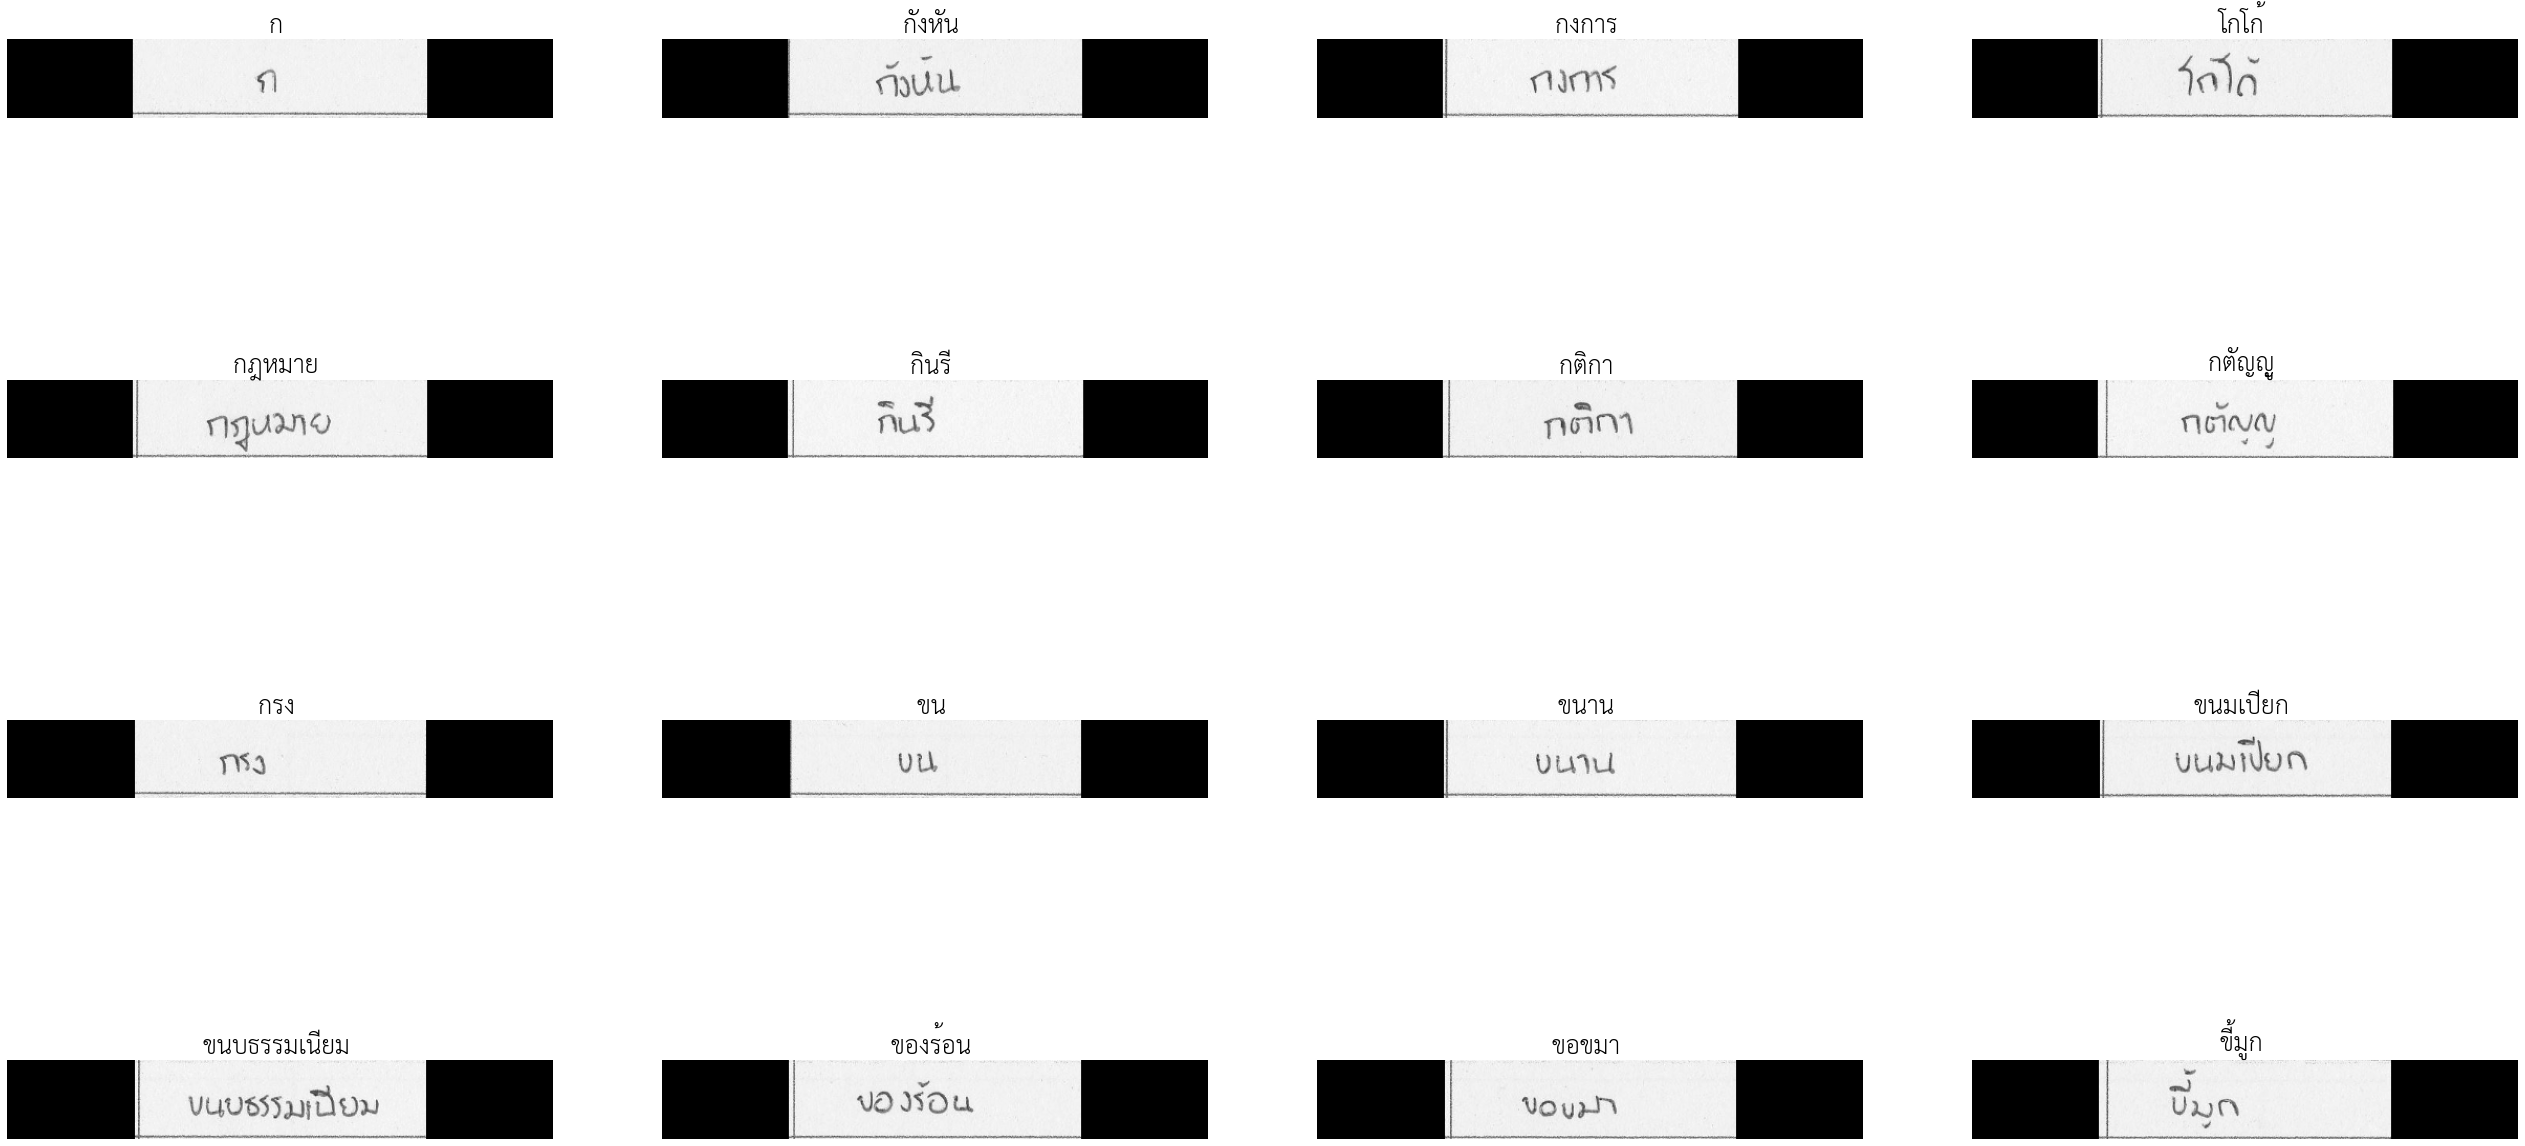

In [ ]:
for data in train_ds.take(1):
    images, labels = data["image"], data["label"]
    
    _, ax = plt.subplots(4, 4, figsize=(45, 24))
    s = 0
    for i in range(s,s+16,1):
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # Gather indices where label!= padding_token.
        label = labels[i]
        
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")

        ax[(i-s) // 4, (i-s) % 4].imshow(img, cmap="gray")
        ax[(i-s) // 4, (i-s) % 4].set_title(label)
        ax[(i-s) // 4, (i-s) % 4].axis("off")


plt.show()

In [ ]:
early_stopping_patience = 10
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

In [ ]:
class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost
        self.ignore_longer_outputs_than_inputs=True
    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions.
        return y_pred


def build_model():
    # Inputs to the model
    input_img = keras.Input(shape=(image_width, image_height, 3), name="image")
    
    labels = keras.layers.Input(name="label", shape=(None,))
   
    x = tf.keras.applications.InceptionV3(include_top=False,
          weights="imagenet",
          input_tensor=None,
          input_shape=(image_width, image_height,3))
    for layer in x.layers:
      layer.trainable = False
    
    
    x= x(input_img)

    new_shape = (448,64)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    # x = keras.layers.Dense(64, activation="relu", name="dense1")(x)
    # x = keras.layers.Dropout(0.2)(x)
   
    # RNNs.
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(128, return_sequences=True, dropout=0.25)
    )(x)
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(64, return_sequences=True, dropout=0.25)
    )(x)

    # +2 is to account for the two special tokens introduced by the CTC loss.
    # The recommendation comes here: https://git.io/J0eXP.
    x = keras.layers.Dense(
        len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step.
    output = CTCLayer(name="ctc_loss")(labels, x)


    # Define the model.
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="handwriting_recognizer"
    )
    # Optimizer.
    opt = keras.optimizers.Adam()
    # Compile the model and return.
    model.compile(optimizer=opt)
    return model



# Get the model.
model = build_model()
model.summary()

Model: "handwriting_recognizer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 521, 75, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 inception_v3 (Functional)      (None, 14, 1, 2048)  21802784    ['image[0][0]']                  
                                                                                                  
 flatten (Flatten)              (None, 28672)        0           ['inception_v3[0][0]']           
                                                                                                  
 reshape (Reshape)              (None, 448, 64)      0           ['flatten[0]

In [ ]:
validation_images = []
validation_labels = []

for batch in validation_ds:
    validation_images.append(batch["image"])
    validation_labels.append(batch["label"])

In [ ]:

def calculate_edit_distance(labels, predictions):
    # Get a single batch and convert its labels to sparse tensors.
    saprse_labels = tf.cast(tf.sparse.from_dense(labels), dtype=tf.int64)

    # Make predictions and convert them to sparse tensors.
    input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
    predictions_decoded = keras.backend.ctc_decode(
        predictions, input_length=input_len, greedy=True
    )[0][0][:, :max_len]
    sparse_predictions = tf.cast(
        tf.sparse.from_dense(predictions_decoded), dtype=tf.int64
    )

    # Compute individual edit distances and average them out.
    edit_distances = tf.edit_distance(
        sparse_predictions, saprse_labels, normalize=False
    )
    return tf.reduce_mean(edit_distances)


class EditDistanceCallback(keras.callbacks.Callback):
    def __init__(self, pred_model):
        super().__init__()
        self.prediction_model = pred_model

    def on_epoch_end(self, epoch, logs=None):
        edit_distances = []

        for i in range(len(validation_images)):
            labels = validation_labels[i]
            predictions = self.prediction_model.predict(validation_images[i])
            edit_distances.append(calculate_edit_distance(labels, predictions).numpy())

        print(
            f"Mean edit distance for epoch {epoch + 1}: {np.mean(edit_distances):.4f}"
        )

In [ ]:
model = build_model()
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
edit_distance_callback = EditDistanceCallback(prediction_model)

In [ ]:
epochs = 100  # To get good results this should be at least 50.
# Train the model.
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs,
    callbacks=[edit_distance_callback],
)

Epoch 1/100
14/14 [==============================] - 28s 762ms/step - loss: 533.3983 - val_loss: 34.1663
Epoch 2/100
14/14 [==============================] - 3s 238ms/step - loss: 36.7333 - val_loss: 36.7186
Epoch 3/100
14/14 [==============================] - 3s 236ms/step - loss: 33.3986 - val_loss: 29.4293
Epoch 4/100
14/14 [==============================] - 3s 237ms/step - loss: 27.9362 - val_loss: 27.2855
Epoch 5/100
14/14 [==============================] - 3s 236ms/step - loss: 26.9956 - val_loss: 26.6031
Epoch 6/100
14/14 [==============================] - 3s 237ms/step - loss: 26.4097 - val_loss: 26.3930
Epoch 7/100
14/14 [==============================] - 3s 236ms/step - loss: 26.1900 - val_loss: 26.2624
Epoch 8/100
14/14 [==============================] - 3s 236ms/step - loss: 26.0508 - val_loss: 26.2326
Epoch 9/100
14/14 [==============================] - 3s 238ms/step - loss: 25.9602 - val_loss: 26.2199
Epoch 10/100
14/14 [==============================] - 3s 238ms/step - l

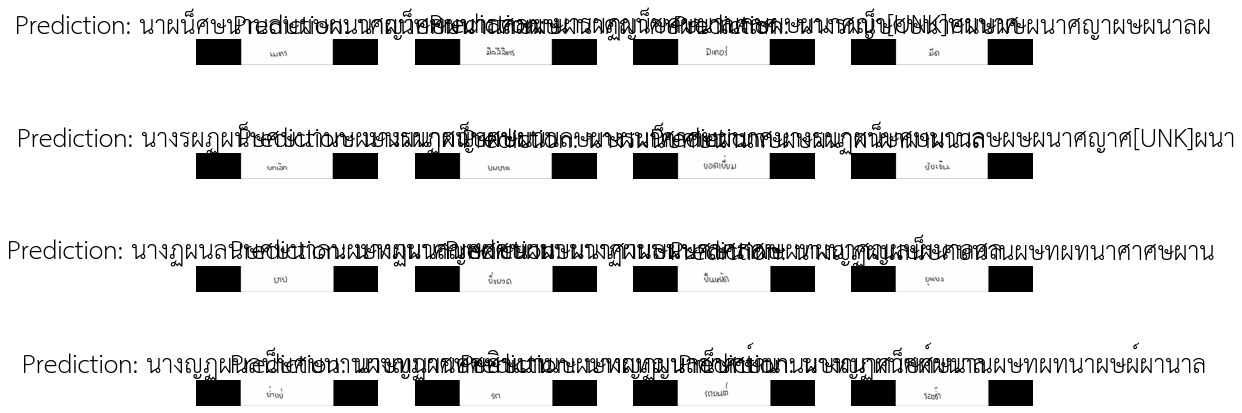

In [ ]:
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some test samples.
for batch in test_ds.take(1):
    batch_images = batch["image"]
    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for i in range(16):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

plt.show()

In [ ]:
 fig, (ax1) = plt.subplots ( figsize=(30, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(2, 14, 1))


legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [ ]:
# model.save('/content/drive/MyDrive/Colab Notebooks/Project Kmitl/STN-CNN-Attention-RNN')

In [ ]:
#  tf.saved_model.save(model,'/content/drive/MyDrive/Colab Notebooks/Project Kmitl/STN-CNN-Attention-RNN')

In [ ]:
from tensorflow import keras
model2 = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Project Kmitl/InceptionV3 on Syn+Data')


In [ ]:
prediction_model2 = keras.models.Model(
    model2.get_layer(name="image").input, 
    model2.get_layer(name="dense2").output
)

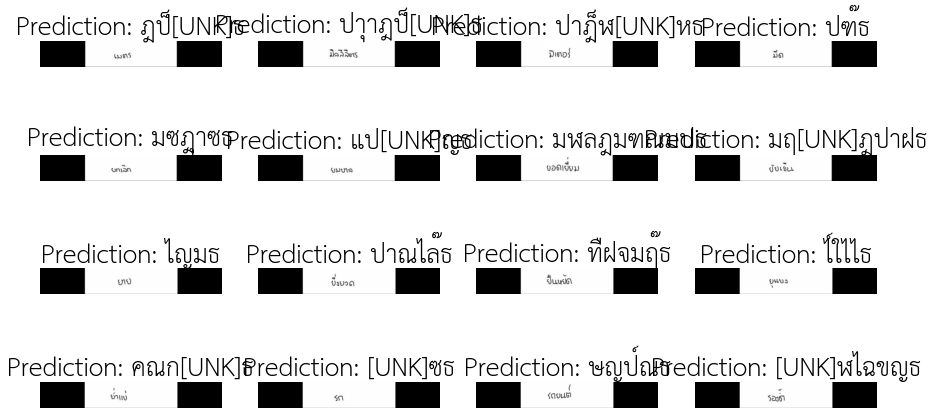

In [ ]:
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some test samples.
for batch in test_ds.take(1):
    batch_images = batch["image"]
    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    preds = prediction_model2.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for i in range(16):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

plt.show()